In [3]:
%matplotlib inline

In [4]:
import sqlite3
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# breakout 1

examine how the file looks like 

In [5]:
!head -10 world.txt

-140.37	60.25
-132.08	57.2
-131.46	55.98
-133.84	57.12
-136.01	59.12
-137.12	58.28
-139.98	59.73
-146.54	60.36
-149.9	59.5
-149.18	60.81


In [6]:
lat, lon = np.loadtxt("world.txt", unpack=True, dtype="float, float")

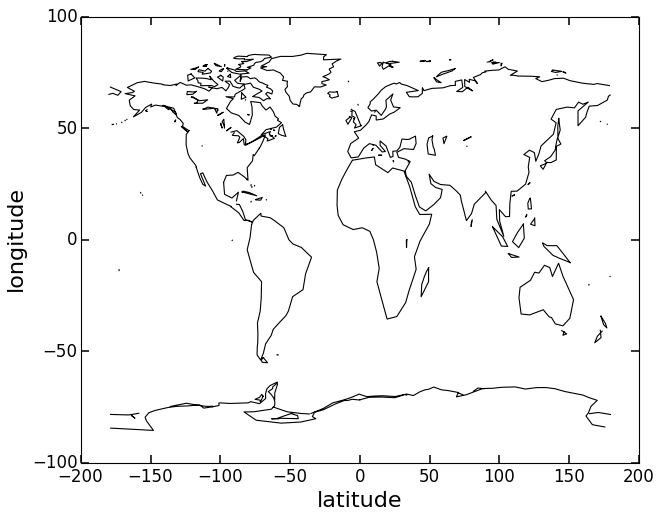

In [7]:
plt.plot(lat, lon, 'k-')
plt.xlabel("latitude")
plt.ylabel("longitude")

# breakout 2 

In [8]:
!head stations_list.txt

CODE,LATITUDE,LONGITUDE,ELEVATION,NETWORK,STATUS,NAME
-A0MA, 46.6886,-106.2222,  897.0,LRSM,Closed,Subarray A0 LASA
034A, 27.0647, -98.6833,  155.0,USTA,Open,Hebronville
035A, 26.9379, -98.1023,   29.0,USTA,Open,Encino
035Z, 26.4630, -98.0683,   19.0,USTA,Open,Hargill
121A, 32.5324,-107.7851, 1652.0,USTA,Open,Cookes Peak; Deming
128A, 32.6213,-102.4850,  966.0,USTA,Open,Castleberry Farm; Seminole
129A, 32.6309,-101.8662,  876.0,USTA,Open,Stewart Farms; Lamesa
130A, 32.5961,-100.9652,  676.0,USTA,Open,Snyder
131A, 32.6737,-100.3888,  622.0,USTA,Open,Roby


there are some nans

can use 
```
data = pd.read_csv("stations_list.txt")
```

In [9]:
with open("stations_list.txt") as f:
    header = f.readline()

In [10]:
headers = header.rstrip().lower().split(",")

In [11]:
header = header.rstrip().lower()

In [12]:
header

'code,latitude,longitude,elevation,network,status,name'

## how to handle NANs

Need to convert all the nan values into NULL

In [18]:
stations = np.genfromtxt("stations_list.txt", delimiter=",", skiprows=1,
                         dtype="S20, float, float, float, <S20, <S20, <S100",
                         missing_values="nan", filling_values=None) 

In [115]:
len(stations)

14730

In [83]:
def handle_nan(s):
    if (type(s) is np.float64 and np.isnan(s)) or \
       s == '':
        return "NULL" 
    else:
        return s

In [95]:
connection = sqlite3.connect("/tmp/breakout2.db")

In [96]:
cursor = connection.cursor()
sql_cmd = "CREATE TABLE stations " + \
        "(id INTEGER PRIMARY KEY AUTOINCREMENT, " + \
        "{0} TEXT, {1} FLOAT, {2} FLOAT, ".format(*headers[:3]) + \
        "{0} FLOAT, {1} TEXT, {2} TEXT, {3} TEXT)".format(*headers[3:]) 
cursor.execute(sql_cmd)

In [97]:
for s in stations:
    s = [handle_nan(string) for string in s]
    sql_cmd = "INSERT INTO stations (" + header + ") VALUES " +  \
        str(tuple(s))
    cursor.execute(sql_cmd)

# 3. Query the database 

In [134]:
sql_cmd = """SELECT latitude, longitude from stations WHERE status = 'Open' and
            latitude != 'NULL' AND longitude != 'NULL'"""
cursor.execute(sql_cmd)
open_data = np.array(cursor.fetchall())

In [127]:
sql_cmd = """SELECT latitude, longitude from stations WHERE status = 'Reserved' and
             latitude != 'NULL' AND longitude != 'NULL'"""
cursor.execute(sql_cmd)
reserve_data = np.array(cursor.fetchall()) 

In [128]:
sql_cmd = """SELECT latitude, longitude from stations WHERE status = 'Closed' and
             latitude != 'NULL' AND longitude != 'NULL'"""
cursor.execute(sql_cmd)
close_data = np.array(cursor.fetchall()) 

make sure that the length of data we get is smaller than total length 
of data base due to nan

In [135]:
assert len(close_data) + len(open_data) + len(reserve_data) < len(stations)

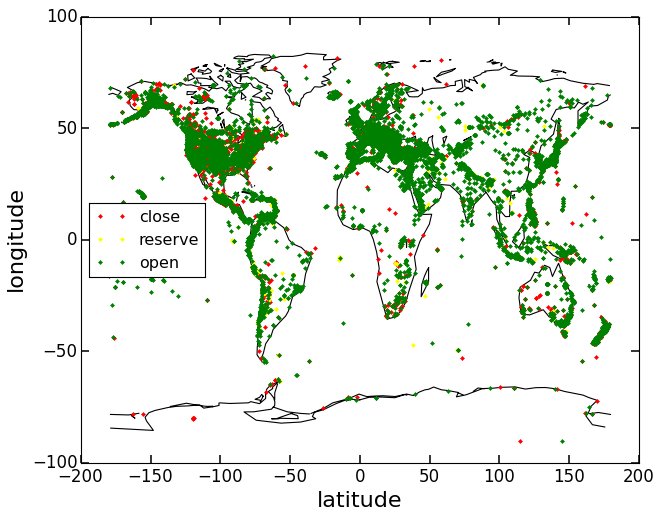

In [136]:
plt.plot(lat, lon, 'k-')
plt.xlabel("latitude")
plt.ylabel("longitude")

plt.plot(close_data[:, 1], close_data[:, 0], 'r.', label="close")
plt.plot(reserve_data[:, 1], reserve_data[:, 0], '.', color='yellow', 
         label="reserve")
plt.plot(open_data[:, 1], open_data[:, 0], 'g.', label="open",)
plt.legend(loc='best', frameon=True)

In [137]:
cursor.close()
connection.close()